In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import string
import os
from collections import defaultdict

pd.set_option("display.max_rows",10)

## Loading data

In [4]:
train = pd.read_csv('train.csv', sep=',', encoding='utf8')
test = pd.read_csv('test.csv', sep=',', encoding='utf8')
print("Training set shape: {} \nTest set shape: {}".format(train.shape, test.shape))

Training set shape: (159571, 8) 
Test set shape: (153164, 2)


In [5]:
n_train = train.shape[0]
n_test = test.shape[0]

In [6]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
# no missing value
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
# Checking statistics of the labels in the training set
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
# number of positive examples for each label
pd.DataFrame(train.iloc[:, 2:8].sum()).transpose()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,15294,1595,8449,478,7877,1405


In [10]:
# more detailed count for different toxic comments

labels = train.columns[2:8].tolist()
grp = train.iloc[:,1:8].groupby(labels)

pd.set_option("display.max_rows",50)
print(grp.count())
pd.set_option("display.max_rows",10)

                                                        comment_text
toxic severe_toxic obscene threat insult identity_hate              
0     0            0       0      0      0                    143346
                                         1                        54
                                  1      0                       301
                                         1                        28
                           1      0      0                        22
                                  1      0                         3
                   1       0      0      0                       317
                                         1                         3
                                  1      0                       181
                                         1                        18
                           1      0      0                         2
                                  1      0                         2
1     0            0       0      

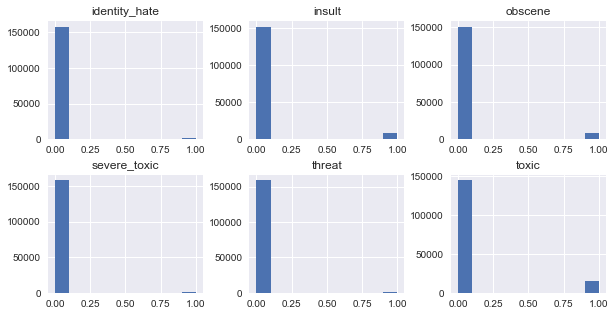

In [11]:
# visuallize the distribution of value for different labels
train.hist(figsize=(10,5), layout=(2,3))
plt.show()

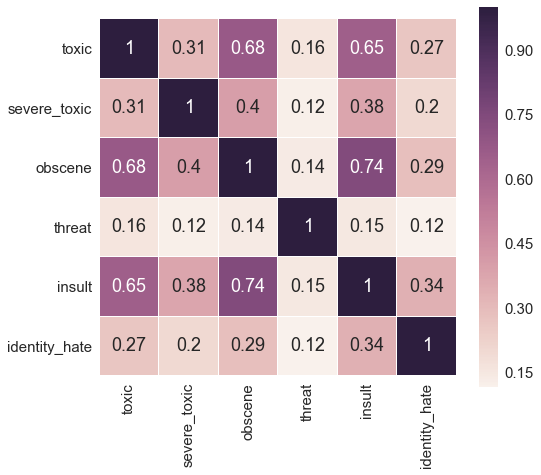

In [12]:
# checking correlation of different lables

plt.figure(figsize=(8,7))
sns.set(font_scale=1.5)
plt.yticks(rotation=0)
sns.heatmap(train.iloc[:,2:].corr(method='spearman'), annot=True, square=True, linewidths=0.1)
plt.show()

## Text preprocessing


In [13]:
full_set = pd.concat([train,test], axis=0, ignore_index=True)
full_set

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0
1,D'aww! He matches this background colour I'm s...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0
2,"Hey man, I'm really not trying to edit war. It...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0
3,"""\nMore\nI can't make any real suggestions on ...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0
4,"You, sir, are my hero. Any chance you remember...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
312730,". \n i totally agree, this stuff is nothing bu...",fffcd0960ee309b5,NaN,NaN,NaN,NaN,NaN,NaN
312731,== Throw from out field to home plate. == \n\n...,fffd7a9a6eb32c16,NaN,NaN,NaN,NaN,NaN,NaN
312732,""" \n\n == Okinotorishima categories == \n\n I ...",fffda9e8d6fafa9e,NaN,NaN,NaN,NaN,NaN,NaN
312733,""" \n\n == """"One of the founding nations of the...",fffe8f1340a79fc2,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
import spacy
nlp = spacy.load('en_core_web_lg') 

from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

In [15]:
# update punctuation in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_punct = True

In [16]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [17]:
def nlp_to_remove(token):
    return(token.is_stop or                                                # remove stop words
           token.is_punct or                                               # reomve punctuations
           token.is_space or                                               # remove white space char
           token.lemma_=='-PRON-'                                          # fixing '-PRON-' issue
           )

def nlp_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in nlp.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not nlp_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
        res['tokenized'].append(lemma_token)                                                  # list of tokens
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # number of char
        res['n_words'].append(m)                                                              # number of words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} min".format(n, (time.time()-start_time)/60))
    return(res)

def token_to_remove(token):    
    return(token.is_punct or 
           token.is_space or 
           token.lemma_.lower() in nlp.Defaults.stop_words                                   # is_stop not working with lg model
           )
    
def token_pip(comment_column, n_cores=cores):
    res = defaultdict(list)
    n = 0
    start_time = time.time()
    for doc in tokenizer.pipe(comment_column, n_threads=cores):
        filtered_tokens = [token for token in doc if not token_to_remove(token)]
        m = len(filtered_tokens)
        if m>0:
            res['caps'].append(sum([token.is_upper for token in filtered_tokens])/m)          # percentage of upper words
            res['longest_word'].append(max([len(token) for token in filtered_tokens]))        # length of the longest word
        else:
            res['caps'].append(0)
            res['longest_word'].append(0)
        lemma_token = [token.lemma_.lower() for token in filtered_tokens]
#         res['tokenized'].append([token.lemma_.lower() for token in filtered_tokens])        
        res['cleaned_text'].append(' '.join(lemma_token))                                     # recombined text
        res['len_doc'].append(len(doc))                                                       # length of doc
        res['n_words'].append(m)                                                              # number of filtered words
        res['oov'].append(sum([token.is_oov for token in filtered_tokens]))                   # count of out of vocabulary words 
        n += 1
        if n%10000 ==0:
            print("finished {} iterattions, elapsed time: {:.2f} s".format(n, time.time()-start_time))
    return(res)

def token_combine(nested_list):
    combined_doc = []
    for i in range(len(nested_list)):
        combined_doc.append(' '.join(nested_list[i]))
    return(combined_doc)

In [18]:
%%time

# takes a few minutes to process

if not os.path.exists('full_cleaned.pkl') or 0==1:
    print("start processing text...")
    
    # processing url, ip address and punctuations
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r"(https|http)\S+", "", x))
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r'[0-9]+(\.[0-9]+){3}', 'ipaddress', x))
    full_set.comment_text = full_set.comment_text.apply(lambda x: re.sub(r'([{}])'.format(string.punctuation),
                                                                         ' \g<1> ', x))  # “”¨«»®´·º½¾¿¡§£₤‘’
    
#     features = nlp_pip(full_set.comment_text)            # this one takes long time
    features = token_pip(full_set.comment_text)      # this one much faster
    for k in features:
        if k=='cleaned_text':
            full_set[k] = features[k]
        else:
            full_set[k] = features[k]/np.std(features[k])    # normalize
    print('Saving dataframe...')
    full_set.to_pickle('full_cleaned.pkl')
else:
    full_set = pd.read_pickle('full_cleaned.pkl')

Wall time: 1.01 s


In [19]:
full_set

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
0,Explanation\nWhy the edits made under my usern...,0000997932d777bf,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,11,explanation edit username hardcore metallica f...,58,25,0
1,D ' aww ! He matches this background colour I...,000103f0d9cfb60f,0.0,0.0,0.0,0.0,0.0,0.0,0.133333,10,d aww match background colour seemingly stick ...,39,15,0
2,"Hey man , I ' m really not trying to edit war...",000113f07ec002fd,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,11,hey man try edit war s guy constantly remove r...,53,20,0
3,""" \nMore\nI can ' t make any real suggestions...",0001b41b1c6bb37e,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,11,t real suggestion improvement wonder section s...,154,49,0
4,"You , sir , are my hero . Any chance you re...",0001d958c54c6e35,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8,sir hero chance remember page s,22,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312730,". \n i totally agree , this stuff is nothin...",fffcd0960ee309b5,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7,totally agree stuff long crap,18,5,0
312731,= = Throw from out field to home plate . ...,fffd7a9a6eb32c16,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,8,throw field home plate fast throw cut man dire...,51,16,0
312732,""" \n\n = = Okinotorishima categories = ...",fffda9e8d6fafa9e,NaN,NaN,NaN,NaN,NaN,NaN,0.071429,14,okinotorishima category change agree correct c...,132,28,3
312733,""" \n\n = = "" "" One of the founding nati...",fffe8f1340a79fc2,NaN,NaN,NaN,NaN,NaN,NaN,0.044444,11,found nation eu germany law return similar isr...,149,45,1


**check an example**

In [20]:
# example comment in train set before and after processing

idx = list(train.id).index('001956c382006abd')
print(train.comment_text[idx])
print(full_set.cleaned_text[idx])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82
sorry sorry screw someones talk page bad know template talk page help assert dominance know bow almighty administrator play outside mom ipaddress


In [21]:
# example comment in test set before and after processing

idx2 = 999
print(test.comment_text[idx2])
print(full_set.cleaned_text[n_train+idx2])

FAT KID POOPS IN HIDS MOTHERNESS!!!!!!!! FREE SESSION ON LEARNING HOW TO POOP ON TUESDAYS AT THE PARK WITH A KITTEN WITH POOPNESS!!!!!!!!
fat kid poops hids motherness free session learning poop tuesdays park kitten poopness


**Some more EDA**

In [22]:
# number of unique words in train, test and full set. Large amount of non-overlapping words in train and test set

from itertools import chain
full_words = set(chain(*[text.split() for text in full_set.cleaned_text]))
train_words = set(chain(*[text.split() for text in full_set.cleaned_text[:n_train]]))
test_words = set(chain(*[text.split() for text in full_set.cleaned_text[n_train:]]))
common_words = train_words & test_words
print('number of unique words in full set: {}'.format(len(full_words)))
print('number of unique words in train set: {}'.format(len(train_words)))
print('number of unique words in test set: {}'.format(len(test_words)))
print('number of unique words in both train and test set: {}'.format(len(common_words)))

number of unique words in full set: 339501
number of unique words in train set: 173819
number of unique words in test set: 239113
number of unique words in both train and test set: 73431


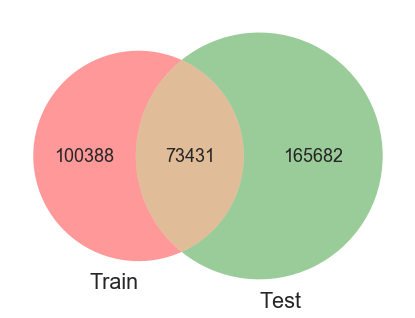

In [23]:
# visuallize the overlapping unique words in train and test set

from matplotlib_venn import venn2

venn2(subsets = (173819-73431, 239113-73431, 73431), set_labels = ('Train', 'Test'))
plt.show()

In [24]:
# Majority of the words in toxic comments are common words also in test set. There are still ~27% words
# in toxic train comments, but not seen in test comments
# using features by tfidf with analyzer='char' should help to reduce this problem

toxic_comments_idx = train.iloc[:,2:8].any(axis=1)
print('Total number of toxic comments in train set: {}'.format(toxic_comments_idx.sum()))
words_in_toxic_comments = set(chain(*[text.split() for text in full_set[:n_train][toxic_comments_idx].cleaned_text]))
print('Number of words in toxic comments: {}'.format(len(words_in_toxic_comments)))
print('-'*50)
print('Number of common words in toxic comments: {}'.format(len(words_in_toxic_comments & common_words)))
print('Number of train only words in toxic comments: {}'.format(len(words_in_toxic_comments & (train_words - common_words))))

Total number of toxic comments in train set: 16225
Number of words in toxic comments: 30847
--------------------------------------------------
Number of common words in toxic comments: 22285
Number of train only words in toxic comments: 8562


In [25]:
# frequent words in toxic comments:

from collections import Counter
toxic_word_freq = Counter(list(chain(*[text.split() for text in full_set[:n_train][toxic_comments_idx].cleaned_text])))

In [26]:
toxic_word_freq.most_common(1000)[-50:]

[('oi', 70),
 ('bill', 70),
 ('culture', 69),
 ('male', 69),
 ('advice', 69),
 ('wife', 69),
 ('date', 69),
 ('basically', 69),
 ('angry', 69),
 ('lady', 69),
 ('bestfrozen', 69),
 ('red', 69),
 ('vuvuzelas', 69),
 ('disruptive', 68),
 ('dispute', 68),
 ('gg', 68),
 ('share', 68),
 ('medium', 68),
 ('effort', 68),
 ('offend', 68),
 ('actual', 68),
 ('18', 68),
 ('uncivil', 68),
 ('controversial', 68),
 ('sup', 68),
 ('recent', 67),
 ('islam', 67),
 ('goodbye', 67),
 ('land', 67),
 ('motherfucking', 67),
 ('father', 67),
 ('star', 67),
 ('theory', 67),
 ('multiple', 67),
 ('thousand', 67),
 ('purpose', 67),
 ('figure', 67),
 ('npov', 67),
 ('lead', 67),
 ('position', 67),
 ('team', 67),
 ('vote', 67),
 ('repeatedly', 67),
 ('result', 67),
 ('billj', 67),
 ('lolooolbootstoots', 67),
 ('jump', 66),
 ('neutral', 66),
 ('situation', 66),
 ('honestly', 66)]

In [27]:
# Checking features generated
full_set.iloc[:, 8:].describe()

,caps,longest_word,len_doc,n_words,oov
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000
mean,0.051442,10.899404,95.966681,31.321793,1.479131
std,0.147328,33.362138,159.567066,54.541409,12.802441
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.000000,24.000000,7.000000,0.000000
50%,0.000000,10.000000,51.000000,16.000000,0.000000
75%,0.041667,12.000000,104.000000,33.000000,1.000000
max,1.000000,4955.000000,9934.000000,1963.000000,1231.000000


In [28]:
# comments that are all uppercase words
full_set[full_set.caps>6]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov


In [29]:
# comments that ended up with no token after processing
full_set[full_set.n_words==0]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
627,Seems we both have some .,01ad9cd4eb4a53c3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,6,0,0
899,I ' ve just seen that,0278c8c0d71aec70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,6,0,0
2009,"No , I ' ve not seen anything .",05729c95eb3dc41c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,10,0,0
2407,"Here , here and here .",067638a445ccd93b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,7,0,0
5198,Who are you showing it to ?,0dd89223c129d0d4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309172,"Well ( * ^ # & % % ) ( @ # you , ...",fa0b49ac1e36b739,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,,38,0,0
309212,: This has since been done .,fa1d8cdba2cd3ca1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,,8,0,0
309519,( ),faa0510471f87cb7,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,,4,0,0
309847,what about as a last name ?,fb2910e8ce01f045,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,,7,0,0


In [30]:
# abnormal long word
full_set[full_set.longest_word>100]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
1876,YOUR ARE FUCKING GAY WAD ! ! ! ! ! ! ! ...,0512b588a4b80e45,1.0,1.0,1.0,0.0,0.0,1.0,0.809524,322,fucking gay wad fuck mum oh wait gay dont mom ...,508,63,18
11796,= = U R GAY = = \n\nFUCKFUCKFUCKFUCKFUCKFU...,1f31848ca28571da,1.0,1.0,1.0,1.0,0.0,1.0,1.000000,4955,u r gay fuckfuckfuckfuckfuckfuckfuckfuckfuckfu...,12,4,1
12964,"Hello , 24 - 7水野 , and welcome to Wikipedia ...",2256374810e57006,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,104,hello 24 7水野 welcome wikipedia effort improve ...,92,31,3
17945,Yamla _ likes _ to _ fuck _ babies _ up _ the ...,2f6282bf19d1b9ce,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,132,yamla like fuck baby ass wwwwwwwwwwwwwwwwwwwww...,39,15,3
18888,Small TextInsert non - formatted text here [ ...,31d9e971fd76329d,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1412,small textinsert non format text media media e...,69,29,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308749,= = I lllllllllllllllllllllllllllllllllluuu...,f95d10dde1ed32ab,NaN,NaN,NaN,NaN,NaN,NaN,0.018519,129,lllllllllllllllllllllllllllllllllluuuuuuuuuuuu...,402,54,9
308846,my huge cock u fatt looser bastad 648942567724...,f982767625efbf20,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,329,huge cock u fatt loose bastad 6489425677246980...,39,21,10
308950,RASASSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,f9b8632d1444cacd,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,262,rasassssssssssssssssssssssssssssssssssssssssss...,4,4,4
310416,I hate you long time go die I HATE YOU DONT DE...,fc2a7b5abfa35466,NaN,NaN,NaN,NaN,NaN,NaN,0.636364,856,hate long time die hate dont delete friends ed...,113,66,12


In [31]:
# abnormal number of oov words
full_set[full_set.oov>20]

,comment_text,id,identity_hate,insult,obscene,severe_toxic,threat,toxic,caps,longest_word,cleaned_text,len_doc,n_words,oov
126,"Ahh , Hello Witzeman \n\nipaddress \nSymbols...",00510c3d06745849,0.0,0.0,0.0,0.0,0.0,0.0,0.249017,14,ahh hello witzeman ipaddress symbols ↔ ↑ ↓ ¶ ½...,1281,763,309
160,""" = = Attributing and classifying of perso...",0063a8786a7034fc,0.0,0.0,0.0,0.0,0.0,0.0,0.017804,15,attributing classify personality invitation in...,841,337,31
321,""" \n\nipaddress ' s rant\n\nPresently , we a...",00ced92ee28c7ee8,0.0,0.0,0.0,0.0,0.0,0.0,0.004515,13,ipaddress s rant presently witness open war cr...,1116,443,81
666,""" { | class = "" "" wikitable "" "" style ...",01cec91ecf91d6ff,0.0,0.0,0.0,0.0,0.0,0.0,0.008929,15,class wikitable style border 1px solid 8888aa ...,385,112,22
1184,"And \n\nPaganism\n\nSouthgate , who has a deg...",0334049b60e326b8,0.0,0.0,0.0,0.0,0.0,0.0,0.008949,14,paganism southgate degree theology religious s...,908,447,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312505,سوال ۱۰ \n سوال ۱۰ ۔ کیا اُم المومنین حضرت عائ...,ff9bbe71e8996418,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,11,سوال ۱۰ سوال ۱۰ کیا اُم المومنین حضرت عائشہؓ ک...,1143,1076,770
312527,""" \n\n To reply on what Frank Close actually...",ffa6dfca382e221b,NaN,NaN,NaN,NaN,NaN,NaN,0.019126,15,reply frank close actually extracts chapter 9 ...,1102,366,31
312631,""" \n\n = = "" "" Armenian Mountains "" "" ...",ffd93a82ac72115b,NaN,NaN,NaN,NaN,NaN,NaN,0.092784,13,armenian mountains incorrect hurrians cames ar...,343,97,21
312669,""" \n\n = = WikiProject Christianity Newsl...",ffe54d29b90968a7,NaN,NaN,NaN,NaN,NaN,NaN,0.012308,12,wikiproject christianity newsletter june 2009 ...,1148,325,23


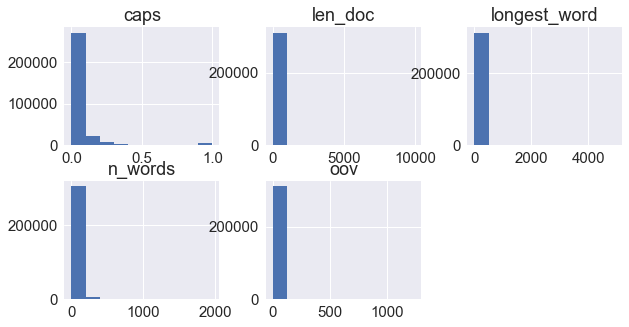

In [32]:
# visuallize the distribution of features
full_set.iloc[:, 8:].hist(figsize=(10,5), layout=(2,3))
plt.show()

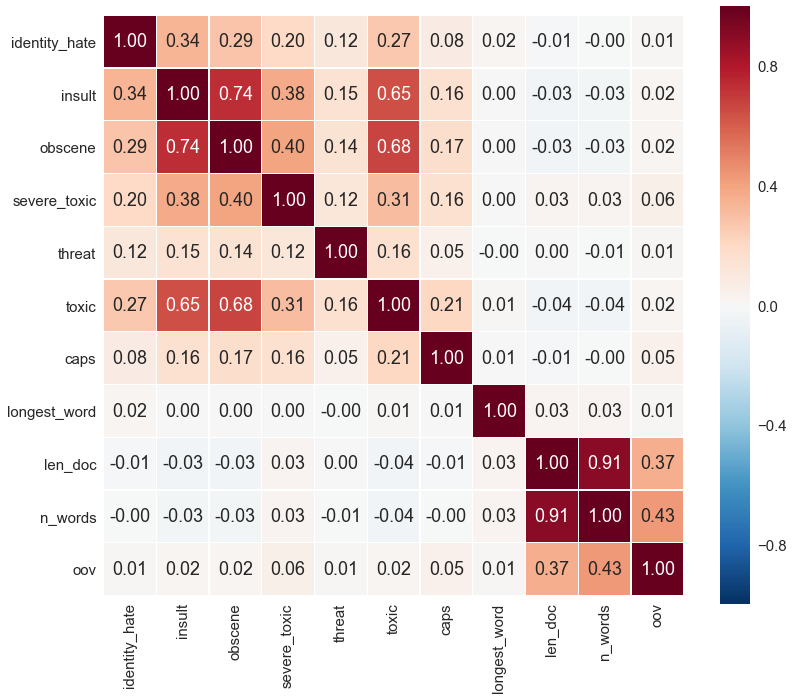

In [33]:
# checking correlation in the train set

plt.figure(figsize=(13,11))
sns.set(font_scale=1.5)
sns.heatmap(full_set.iloc[:n_train,2:].corr(), annot=True, square=True, linewidths=0.1, fmt='.2f')
plt.show()

## comments to vector

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from scipy.sparse import hstack

**parameters: max_df, min_df, ngrame_range, max_features**

In [85]:
%%time

# Takes few minutes to process
word_tfidf = TfidfVectorizer(analyzer='word', max_df=0.2, min_df=0.0001)
x_word = word_tfidf.fit_transform(full_set.cleaned_text)
char_tfidf = TfidfVectorizer(analyzer='char', max_df=0.15, min_df=0.0003, ngram_range=(1,5), max_features=40000)
x_char = char_tfidf.fit_transform(full_set.cleaned_text)
print(x_word.shape, x_char.shape)

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(312735, 12855) (312735, 40000)
Wall time: 5min 56s


In [87]:
x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set['toxic'][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set['toxic'][:n_train])

In [88]:
weight = [1, 0.25]
x_train_comb = hstack([x_word[train_idx]*weight[0], x_char[train_idx]*weight[1]])
x_test_comb = hstack([x_word[test_idx]*weight[0], x_char[test_idx]*weight[1]])
x_sub_comb = hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]])
x_train_comb

<127656x52855 sparse matrix of type '<class 'numpy.float64'>'
	with 51435346 stored elements in COOrdinate format>

## Multinomial naive Bayes

In [89]:
%%time

# try on a single label
# use 1:0.3 joined word char features better than 1:1 for toxic label
mnb = MultinomialNB()
parameters = {'alpha': (1, 0.6, 0.4, 0.2, 0.1)}
nb_toxic = GridSearchCV(mnb, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
nb_toxic.fit(x_train_comb, y_train)
print(nb_toxic.best_params_)
print(nb_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, nb_toxic.predict_proba(x_train_comb)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, nb_toxic.predict_proba(x_test_comb)[:,1])))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.2min finished


{'alpha': 0.2}
0.9551830252802104
Training score(roc_auc): 0.967056108699374
Test score(roc_auc): 0.9586210870621062
Wall time: 2min 14s


### multi label models

In [34]:
%%time

mnb_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
mnb_submission = pd.read_csv('sample_submission.csv')
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    weight = [1, 0.3]
    x_train_comb = hstack([x_word[train_idx]*weight[0], x_char[train_idx]*weight[1]])
    x_test_comb = hstack([x_word[test_idx]*weight[0], x_char[test_idx]*weight[1]])
    x_sub_comb = hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]])
    mnb = MultinomialNB()
    parameters = {'alpha': (0.2, 0.15, 0.1, 0.05, 0.03)}
    mnb_cv = GridSearchCV(mnb, parameters, n_jobs=-1, scoring = 'roc_auc', cv=5)
    mnb_cv.fit(x_train_comb, y_train)
    mnb_records.loc[label,'best_params'] = str(mnb_cv.best_params_)
    mnb_records.loc[label,'cv_score'] = mnb_cv.best_score_
    mnb_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, mnb_cv.predict_proba(x_train_comb)[:,1])
    mnb_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, mnb_cv.predict_proba(x_test_comb)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*mnb_records.loc[label]))
    mnb.set_params(**mnb_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    mnb.fit(hstack([x_word[:n_train]*weight[0], x_char[:n_train]*weight[1]]), full_set[label][:n_train])
    mnb_submission[label] = mnb.predict_proba(hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]]))[:,1]
    

Start training classifier on toxic label
Best params: {'alpha': 0.2}, cv_score: 0.953085464608997, train_score: 0.9642777587057523, test_score: 0.9572685514517963
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Best params: {'alpha': 0.05}, cv_score: 0.9792746002817502, train_score: 0.9907503481315494, test_score: 0.9779548798089991
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Best params: {'alpha': 0.15}, cv_score: 0.9628703189390334, train_score: 0.9743467421973552, test_score: 0.9623762902491668
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Best params: {'alpha': 0.03}, cv_score: 0.9598730252145119, train_score: 0.9924866822760343, test_score: 0.9565077403961993
Fitting final model and making prediction for submission on threat label
Start training classifier on insul

In [35]:
mnb_records

,best_params,cv_score,train_score,test_score
toxic,{'alpha': 0.2},0.953085,0.964278,0.957269
severe_toxic,{'alpha': 0.05},0.979275,0.99075,0.977955
obscene,{'alpha': 0.15},0.96287,0.974347,0.962376
threat,{'alpha': 0.03},0.959873,0.992487,0.956508
insult,{'alpha': 0.1},0.959598,0.973281,0.963868
identity_hate,{'alpha': 0.05},0.959401,0.98531,0.96861


In [36]:
mnb_records.iloc[:,1:].mean()

cv_score       0.962351
train_score    0.980075
test_score     0.964431
dtype: float64

In [77]:
mnb_submission.to_csv('mnb_submission.csv',index=False)

# mnb: 
- using weight(1, 0.3) to join word and char features better than 1:1 join

{'alpha': 0.2}
0.953085464608997
Training score(roc_auc): 0.9642777587057523
Test score(roc_auc): 0.9572685514517963

0.2  0.05  0.15 0.03 0.1 0.05

cv_score       0.962351
train_score    0.980075
test_score     0.964431

kaggle score: 0.9555

## with pipline single label

In [37]:
x_train, x_test, y_train, y_test = train_test_split(full_set.cleaned_text[:n_train], 
                                                    full_set['toxic'][:n_train], 
                                                    test_size = 0.2, 
                                                    stratify = full_set['toxic'][:n_train])
pipe_nb_toxic = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [81]:
%%time
# just word features
parameters = {'tfidf__max_df': [0.2],\
              'tfidf__min_df': [0.0001],\
              'nb__alpha': [0.4]
             }
mnb_word_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
mnb_word_toxic.fit(x_train, y_train)
print(mnb_word_toxic.best_params_)
print(mnb_word_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, mnb_word_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, mnb_word_toxic.predict_proba(x_test)[:,1])))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished
C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
0.955109427915134
Training score(roc_auc): 0.9681823150456108
Test score(roc_auc): 0.9572388756271292
Wall time: 47 s


{'nb__alpha': 0.4, 'tfidf__max_df': 0.4, 'tfidf__min_df': 20}
0.9548802633829122

{'nb__alpha': 0.6, 'tfidf__max_df': 0.3, 'tfidf__min_df': 0.0003}
0.9546047253386121

{'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}
0.955109427915134

In [82]:
%%time
# just char features
parameters = {'tfidf__analyzer': ['char'],\
              'tfidf__max_df': [0.15],\
              'tfidf__min_df': [0.0003],\
              'tfidf__ngram_range': [(1,5)],\
              'tfidf__max_features': [40000],\
              'nb__alpha': [0.4]}
mnb_char_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=5)
mnb_char_toxic.fit(x_train, y_train)
print(mnb_char_toxic.best_params_)
print(mnb_char_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, mnb_char_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, mnb_char_toxic.predict_proba(x_test)[:,1])))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  4.8min finished
C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
0.9443888224165012
Training score(roc_auc): 0.9513343689715263
Test score(roc_auc): 0.9467136326762108
Wall time: 8min 51s


{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.2, 'tfidf__max_features': 30000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 4)}
0.939792906316925
Training score(roc_auc): 0.9461465635299896
Test score(roc_auc): 0.941953299598244
Wall time: 4h 30min 5s

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 30000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 5)}
0.9431876996662475
Training score(roc_auc): 0.9487234081778911
Test score(roc_auc): 0.9449681911864919
Wall time: 23min 2s

{'nb__alpha': 0.4, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.15, 'tfidf__max_features': 40000, 'tfidf__min_df': 0.0003, 'tfidf__ngram_range': (1, 5)}
0.9443888224165012
Training score(roc_auc): 0.9513343689715263
Test score(roc_auc): 0.9467136326762108
Wall time: 5h 46min 39s

## with pipeline+Featureunion single label

In [79]:
%%time
pip_mnb_union = Pipeline([
           
            # use FeatureUnion to combine features from tfidf and other already generated features
            ('union', FeatureUnion(
                transformer_list=[
                    
                    # pipeline to generate features from comments using tfidf analyzed by word
                    ('tfidf_word', Pipeline([
                        ('tfidf', TfidfVectorizer(analyzer='word'))
                    ])),
                    
                    # pipeline to generate features from comments using tfidf analyzed by char
                    ('tfidf_char', Pipeline([
                        ('tfidf', TfidfVectorizer(analyzer='char'))
                    ]))
                ],    
                transformer_weights={
                    'tfidf_word': 1.0,
                    'tfidf_char': 0.2,
                }
                
            )),
    
            ('nb', MultinomialNB())
            ])

parameters = {'union__tfidf_word__tfidf__max_df': [0.2],\
              'union__tfidf_word__tfidf__min_df': [0.0001],\
              'union__tfidf_char__tfidf__max_df': [0.15],\
              'union__tfidf_char__tfidf__min_df': [0.0003],\
              'union__tfidf_char__tfidf__max_features': [40000],\
              'union__tfidf_char__tfidf__ngram_range': [(1,5)],\
              'nb__alpha': [0.6,0.4,0.2],
              }

union_mnb_cv = GridSearchCV(pip_mnb_union, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=3)
union_mnb_cv.fit(x_train, y_train)
print(union_mnb_cv.best_params_)
print(union_mnb_cv.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, union_mnb_cv.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, union_mnb_cv.predict_proba(x_test)[:,1])))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  7.3min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 15.1min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 18.5min finished
C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):
C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


{'nb__alpha': 0.2, 'union__tfidf_char__tfidf__max_df': 0.15, 'union__tfidf_char__tfidf__max_features': 40000, 'union__tfidf_char__tfidf__min_df': 0.0003, 'union__tfidf_char__tfidf__ngram_range': (1, 5), 'union__tfidf_word__tfidf__max_df': 0.2, 'union__tfidf_word__tfidf__min_df': 0.0001}
0.955850195663717
Training score(roc_auc): 0.9689354350879801
Test score(roc_auc): 0.9580927452277831
Wall time: 23min 19s


{'nb__alpha': 0.4, 'union__tfidf_char__tfidf__max_df': 0.15, 'union__tfidf_char__tfidf__max_features': 40000, 'union__tfidf_char__tfidf__min_df': 0.0003, 'union__tfidf_char__tfidf__ngram_range': (1, 5), 'union__tfidf_word__tfidf__max_df': 0.2, 'union__tfidf_word__tfidf__min_df': 0.0001}
0.9526365240927905
Training score(roc_auc): 0.9615181461083318
Test score(roc_auc): 0.9547861593721046

{'nb__alpha': 0.2, 'union__tfidf_char__tfidf__max_df': 0.15, 'union__tfidf_char__tfidf__max_features': 40000, 'union__tfidf_char__tfidf__min_df': 0.0003, 'union__tfidf_char__tfidf__ngram_range': (1, 5), 'union__tfidf_word__tfidf__max_df': 0.2, 'union__tfidf_word__tfidf__min_df': 0.0001}
0.955850195663717
Training score(roc_auc): 0.9689354350879801
Test score(roc_auc): 0.9580927452277831
Wall time: 23min 19s

## simple stacking pipline models with word and char features

In [84]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, (mnb_word_toxic.predict_proba(x_train)[:,1]*0.8+
                                                                               mnb_char_toxic.predict_proba(x_train)[:,1]*0.2))))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, (mnb_word_toxic.predict_proba(x_test)[:,1]*0.8+
                                                                          mnb_char_toxic.predict_proba(x_test)[:,1]*0.2))))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Training score(roc_auc): 0.9685301647630753
Test score(roc_auc): 0.9589809694527178


1:1
Training score(roc_auc): 0.9651714798553057
Test score(roc_auc): 0.9568482298458384

4:1
Training score(roc_auc): 0.9685301647630753
Test score(roc_auc): 0.9589809694527178

## model from word features, all labels

In [ ]:
%%time

word_mnb_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
word_mnb_submission = pd.read_csv('sample_submission.csv')
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    word_mnb = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])
    parameters = {'tfidf__max_df': [0.3, 0.2, 0.15],\
                  'tfidf__min_df': [0.00003, 0.0001, 0.0003, 0.001],\
                  'nb__alpha': [0.4, 0.2, 0.1, 0.05, 0.03]
                 }
    word_mnb_cv = GridSearchCV(word_mnb, parameters, n_jobs=-1, scoring = 'roc_auc', cv=5)
    word_mnb_cv.fit(x_train, y_train)
    word_mnb_records.loc[label,'best_params'] = str(word_mnb_cv.best_params_)
    word_mnb_records.loc[label,'cv_score'] = word_mnb_cv.best_score_
    word_mnb_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, word_mnb_cv.predict_proba(x_train)[:,1])
    word_mnb_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, word_mnb_cv.predict_proba(x_test)[:,1])
    print('Best params: {}, cv_score: {}, train_score: {}, test_score: {}'.format(*word_mnb_records.loc[label]))
    word_mnb.set_params(**word_mnb_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    word_mnb.fit(full_set.cleaned_text[:n_train], full_set[label][:n_train])
    word_mnb_submission[label] = word_mnb.predict_proba(full_set.cleaned_text[n_train:])[:,1]

Start training classifier on toxic label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Best params: {'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0001}, cv_score: 0.9550078827130518, train_score: 0.9679276328979506, test_score: 0.9596303256634855
Fitting final model and making prediction for submission on toxic label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Start training classifier on severe_toxic label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Best params: {'nb__alpha': 0.2, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}, cv_score: 0.9789676614405037, train_score: 0.9883241955519528, test_score: 0.9772268899559129
Fitting final model and making prediction for submission on severe_toxic label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Start training classifier on obscene label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Best params: {'nb__alpha': 0.4, 'tfidf__max_df': 0.2, 'tfidf__min_df': 0.0003}, cv_score: 0.9653922123249993, train_score: 0.9738800379820505, test_score: 0.9637549052716068
Fitting final model and making prediction for submission on obscene label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Start training classifier on threat label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Best params: {'nb__alpha': 0.1, 'tfidf__max_df': 0.3, 'tfidf__min_df': 0.001}, cv_score: 0.968654060258725, train_score: 0.9904868948692713, test_score: 0.9657327710382686
Fitting final model and making prediction for submission on threat label


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Start training classifier on insult label


## Logistic Regression

In [123]:
%%time

# use 1:1 joined word char features
lg = LogisticRegression()
parameters = {'C': [0.03, 0.1, 0.3, 0.9],\
             'class_weight': ['balanced'],\
             'solver': ['lbfgs'],\
             }
lg_toxic = GridSearchCV(lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=5)
lg_toxic.fit(x_train_comb, y_train)
print(lg_toxic.best_params_)
print(lg_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, lg_toxic.predict_proba(x_train_comb)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, lg_toxic.predict_proba(x_test_comb)[:,1])))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.9min finished


{'C': 0.3, 'class_weight': 'balanced', 'solver': 'newton-cg'}
0.9794813511602982
Training score(roc_auc): 0.9963089668397781
Test score(roc_auc): 0.9855039073459635
Wall time: 10min 3s


### multi label models

In [38]:
%%time

lg_records = pd.DataFrame(index=labels, columns=['best_params', 'cv_score', 'train_score', 'test_score'])
lg_submission = pd.read_csv('sample_submission.csv')
for label in labels:
    print('Start training classifier on {} label'.format(label))
    x_train, x_test, y_train, y_test, train_idx, test_idx = train_test_split(full_set.cleaned_text[:n_train], 
                                                        full_set[label][:n_train], 
                                                        np.arange(n_train),
                                                        test_size = 0.2, 
                                                        random_state=2018,
                                                        stratify = full_set[label][:n_train])
    weight = [1, 1]
    x_train_comb = hstack([x_word[train_idx]*weight[0], x_char[train_idx]*weight[1]])
    x_test_comb = hstack([x_word[test_idx]*weight[0], x_char[test_idx]*weight[1]])
    x_sub_comb = hstack([x_word[n_train:]*weight[0], x_char[n_train:]*weight[1]])
    lg = LogisticRegression()
    parameters = {'C': [0.1, 0.2, 0.4, 0.8],\
                  'class_weight': ['balanced'],\
                  'solver': ['lbfgs'],\
                 }
    lg_cv = GridSearchCV(lg, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)
    lg_cv.fit(x_train_comb, y_train)
    lg_records.loc[label,'best_params'] = str(lg_cv.best_params_)
    lg_records.loc[label,'cv_score'] = lg_cv.best_score_
    lg_records.loc[label, 'train_score'] = metrics.roc_auc_score(y_train, lg_cv.predict_proba(x_train_comb)[:,1])
    lg_records.loc[label, 'test_score'] = metrics.roc_auc_score(y_test, lg_cv.predict_proba(x_test_comb)[:,1])
    print('Best params: {}, cv_score: {:.6f}, train_score: {:.6f}, test_score: {:.6f}'.format(*lg_records.loc[label]))
    lg.set_params(**lg_cv.best_params_)
    print('Fitting final model and making prediction for submission on {} label'.format(label))
    lg.fit(hstack([x_word[:n_train]*weight[0], x_char[:n_train]*weight[1]]), full_set[label][:n_train])
    lg_submission[label] = lg.predict_proba(x_sub_comb)[:,1]

Start training classifier on toxic label
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.5min finished


Best params: {'C': 0.8, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.973023, train_score: 0.991355, test_score: 0.975484
Fitting final model and making prediction for submission on toxic label
Start training classifier on severe_toxic label
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.7min finished


Best params: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.987395, train_score: 0.993149, test_score: 0.987970
Fitting final model and making prediction for submission on severe_toxic label
Start training classifier on obscene label
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.5min finished


Best params: {'C': 0.4, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.990068, train_score: 0.996483, test_score: 0.989666
Fitting final model and making prediction for submission on obscene label
Start training classifier on threat label
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


Best params: {'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.981855, train_score: 0.998335, test_score: 0.977534
Fitting final model and making prediction for submission on threat label
Start training classifier on insult label
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished


Best params: {'C': 0.4, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.980003, train_score: 0.991660, test_score: 0.978746
Fitting final model and making prediction for submission on insult label
Start training classifier on identity_hate label
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.4min finished


Best params: {'C': 0.2, 'class_weight': 'balanced', 'solver': 'lbfgs'}, cv_score: 0.979516, train_score: 0.995637, test_score: 0.985557
Fitting final model and making prediction for submission on identity_hate label
Wall time: 37min 9s


In [39]:
lg_records

,best_params,cv_score,train_score,test_score
toxic,"{'C': 0.8, 'class_weight': 'balanced', 'solver...",0.973023,0.991355,0.975484
severe_toxic,"{'C': 0.1, 'class_weight': 'balanced', 'solver...",0.987395,0.993149,0.98797
obscene,"{'C': 0.4, 'class_weight': 'balanced', 'solver...",0.990068,0.996483,0.989666
threat,"{'C': 0.1, 'class_weight': 'balanced', 'solver...",0.981855,0.998335,0.977534
insult,"{'C': 0.4, 'class_weight': 'balanced', 'solver...",0.980003,0.99166,0.978746
identity_hate,"{'C': 0.2, 'class_weight': 'balanced', 'solver...",0.979516,0.995637,0.985557


In [40]:
lg_records.iloc[:,1:].mean()

cv_score       0.981977
train_score    0.994437
test_score     0.982493
dtype: float64

In [41]:
lg_submission.to_csv('lg_submission.csv',index=False)

# logistic regression
- [1,1] joined word and char features better than [1,0.3] joined features

{'C': 0.1, 'class_weight': 'balanced', 'solver': 'lbfgs'}
0.9873947097951655
Training score(roc_auc): 0.993149330451378
Test score(roc_auc): 0.9879700358880396
Wall time: 4min 33s

0.8 0.1 0.4 0.1 0.4 0.2

cv_score       0.981977
train_score    0.994437
test_score     0.982493

kaggle score: 0.9774

## Tree

In [135]:
import xgboost

In [136]:
train_df = xgboost.DMatrix(x_train_comb, label = y_train)

In [154]:
%%time

# use 1:1 joined word char features

param = {'eta':0.3,  # learning_rate
         'silent':0,  # printing running messages
         'objective':'binary:logistic', # logistic regression for binary classification, output probability
         'subsample': 1,  # subsample rows
         'scale_pos_weight': 1, # for balancing the classes         
         'colsample_bytree': 0.2,  # subsample columns
         'gamma': 11, # minimum loss reduction required to make a further partition on a leaf node of the tree
         'max_depth':4,  # maximum depth of a tree, 4-10
         'min_child_weight': 5,  # minimum sum of instance weight (hessian) needed in a child
#          'colsample_bylevel': 1, # subsample ratio of columns for each split, in each level
#          'max_delta_step': 0 # help in logistic regression when class is extremely imbalanced, 1-10
         }
xgb_toxic = xgboost.cv(params=param, dtrain=train_df, num_boost_round=500, nfold=3, metrics='auc',\
                   stratified=True, early_stopping_rounds=50,\
                   verbose_eval=True, seed=2018)

# print(lg_toxic.best_params_)
# print(lg_toxic.best_score_)
# print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, lg_toxic.predict_proba(x_train_comb)[:,1])))
# print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, lg_toxic.predict_proba(x_test_comb)[:,1])))

[0]	train-auc:0.796981+0.0109959	test-auc:0.793915+0.0140373
[1]	train-auc:0.840044+0.00536002	test-auc:0.835227+0.00176337
[2]	train-auc:0.855341+0.00357857	test-auc:0.849412+0.00128116
[3]	train-auc:0.872474+0.00264374	test-auc:0.86389+0.00552894
[4]	train-auc:0.882874+0.00193005	test-auc:0.873201+0.00536483
[5]	train-auc:0.890423+0.00134486	test-auc:0.880574+0.00371775
[6]	train-auc:0.895957+0.00222922	test-auc:0.886053+0.00329777
[7]	train-auc:0.901025+0.00183939	test-auc:0.890153+0.00403479
[8]	train-auc:0.905073+0.00109418	test-auc:0.894136+0.00258031
[9]	train-auc:0.909567+0.00118027	test-auc:0.897777+0.00247806
[10]	train-auc:0.914597+0.00127315	test-auc:0.902341+0.0026341
[11]	train-auc:0.918612+0.000832952	test-auc:0.906448+0.00193617
[12]	train-auc:0.921774+0.00163709	test-auc:0.909214+0.00226672
[13]	train-auc:0.924727+0.00224918	test-auc:0.912225+0.00146467
[14]	train-auc:0.928284+0.0020549	test-auc:0.914742+0.00133552
[15]	train-auc:0.931768+0.00152825	test-auc:0.917365+0

[127]	train-auc:0.984978+0.000310459	test-auc:0.958162+0.00140564
[128]	train-auc:0.985044+0.000301753	test-auc:0.95822+0.00138128
[129]	train-auc:0.985204+0.00032011	test-auc:0.958254+0.00143411
[130]	train-auc:0.985301+0.00029648	test-auc:0.95824+0.0014943
[131]	train-auc:0.985395+0.000315274	test-auc:0.958366+0.00145999
[132]	train-auc:0.985485+0.00032092	test-auc:0.95841+0.00137368
[133]	train-auc:0.985563+0.000308775	test-auc:0.958431+0.0013365
[134]	train-auc:0.985689+0.000358371	test-auc:0.958442+0.00138365
[135]	train-auc:0.985793+0.000342098	test-auc:0.958467+0.0014016
[136]	train-auc:0.985865+0.000353201	test-auc:0.95848+0.00136974
[137]	train-auc:0.98595+0.00036762	test-auc:0.958469+0.00144499
[138]	train-auc:0.986056+0.000363803	test-auc:0.95848+0.00146892
[139]	train-auc:0.986117+0.000344475	test-auc:0.958575+0.00150398
[140]	train-auc:0.98619+0.000346898	test-auc:0.958597+0.00145529
[141]	train-auc:0.986295+0.000410759	test-auc:0.958774+0.00143263
[142]	train-auc:0.986389

KeyboardInterrupt: 

- best auc:
[231]	train-auc:0.983466+0.000306972	test-auc:0.962364+0.00119056
[2777]	train-auc:0.984029+0.000176414	test-auc:0.964967+0.00121307

[158]	train-auc:0.983336+0.000192297	test-auc:0.959391+0.000734916
[151]	train-auc:0.983416+0.000487931	test-auc:0.958959+0.000854794

         'eta':0.3, 
         'silent':0,  
         'objective':'binary:logistic', 
         'subsample': 1,  
         'scale_pos_weight': 1,                          9
         'colsample_bytree': 0.2,                        0.3
         'gamma': 11,                                    11
         'max_depth':4,  
         'min_child_weight': 5,                          50
         'colsample_bylevel': 1, 


## nbsvm 

In [48]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, 
                                       n_jobs=self.n_jobs, class_weight='balanced',
                                      solver='sag').fit(x_nb, y)
        return self

In [ ]:
%%time

# 
nbsvm = NbSvmClassifier()
parameters = {'C': [0.01, 0.1, 1, 3],\
             }
svm_toxic = GridSearchCV(nbsvm, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=5, cv=3)
svm_toxic.fit(x_train_comb, y_train)
print(svm_toxic.best_params_)
print(svm_toxic.best_score_)
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, svm_toxic.predict_proba(x_train_comb)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, svm_toxic.predict_proba(x_test_comb)[:,1])))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


## recycle bin

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key='comment', idx=None):
        self.key = key
        self.idx = idx

    def fit(self, x, y=None):
        return(self)

    def transform(self, data_dict):
        if self.key == 'comment':
            return(data_dict[self.key])
        elif self.key == 'features':
            print('Select {}x{} previous generated feature matrix'.format(len(self.idx), 
                                                                          data_dict[self.key].shape[1]))
            return(data_dict[self.key].iloc[self.idx,:])

class CommentFeatureExtractor(BaseEstimator, TransformerMixin):
    '''
    input data should contain cleaned comments from both train and test set
    (first n_train samples from train set, the rest from test set), 
    as well as featurs already generated during text preprocessing
    '''
    def __init__(self, n_train=None):
        self.n_train = n_train
        
    def fit(self, x, y=None):
        return(self)

    def transform(self, full_set):
        data = {}
        data['comment'] = full_set.cleaned_text
        data['features'] = full_set.drop('cleaned_text',axis=1)[:self.n_train]
        print('Extracted {} comments and {} feature matrix'.format(len(data['comment']), data['features'].shape))
        return(data)

class MyTfidf(BaseEstimator, TransformerMixin):
    def __init__(self, max_df=1.0, min_df=1, max_features=None, idx=None, analyzer='word'):
        self.max_df = max_df
        self.min_df = min_df
        self.max_features = max_features
        self.idx = idx
        self.analyzer = analyzer
        
    def fit(self, x, y=None):
        return(self)
    
    def transform(self, comments):
        if self.analyzer == 'word':
            ngram_range=(1, 1)
        elif self.analyzer == 'char':
            ngram_range=(1, 4)
        vectorizer = TfidfVectorizer(max_df=self.max_df, ngram_range=ngram_range, min_df=self.min_df, 
                                          max_features=self.max_features, analyzer=self.analyzer,)
        matrix = vectorizer.fit_transform(comments)
        print('Finished tf-idf from {}, shape of generated matrix: {}x{}'.format(self.analyzer, 
                                                                                 len(self.idx), 
                                                                                 matrix.shape[1]))
        return(matrix[self.idx])

In [35]:
pip = Pipeline([
            # Extract comments and features columns
            ('commentfeature', CommentFeatureExtractor()),
            
            # use FeatureUnion to combine features from tfidf and other already generated features
            ('union', FeatureUnion(
                transformer_list=[
                    
                    # pipeline to generate features from comments using tfidf analyzed by word
                    ('tfidf_word', Pipeline([
                        ('selector', ItemSelector(key='comment')),
                        ('tfidf', MyTfidf(analyzer='word'))
                    ])),
                    
                    # pipeline to generate features from comments using tfidf analyzed by char
                    ('tfidf_char', Pipeline([
                        ('selector', ItemSelector(key='comment')),
                        ('tfidf', MyTfidf(analyzer='char'))
                    ])),
                    
                    # get other generated features 
#                     ('other_features', Pipeline([
#                         ('selector', ItemSelector(key='features'))
#                     ]))
                ], 
#                 n_jobs=-1,
                transformer_weights={
                    'tfidf_word': 1.0,
                    'tfidf_char': 1.0,
#                     'other_features': 1.0,
                }
            )),            
            ])

Pipeline(memory=None,
     steps=[('commentfeature', CommentFeatureExtractor(n_train=159571)), ('union', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf_word', Pipeline(memory=None,
     steps=[('selector', ItemSelector(idx=None, key='comment')), ('tfidf', MyTfidf(analyzer='word', idx=array([143061,  91099, ...,    35...eatures=30000, min_df=50))]))],
       transformer_weights={'tfidf_word': 1.0, 'tfidf_char': 1.0}))])

In [37]:
# takes a few minutes

%%time
parameters = {'commentfeature__n_train': n_train,\
              'union__tfidf_word__tfidf__max_df': 1.0,\
              'union__tfidf_word__tfidf__min_df': 50,\
              'union__tfidf_word__tfidf__idx': train_idx,\
              'union__tfidf_char__tfidf__max_df': 1.0,\
              'union__tfidf_char__tfidf__min_df': 50,\
              'union__tfidf_char__tfidf__idx': train_idx,\
              'union__tfidf_char__tfidf__max_features': 30000,\
#               'union__other_features__selector__idx': train_idx,\
              }
pip.set_params(**parameters)

x_train_comb = pip.transform(full_set.drop(['comment_text', 'id', 
                                            'identity_hate', 'insult', 
                                            'obscene', 'severe_toxic', 
                                            'threat'], axis=1))

Wall time: 0 ns
Extracted 312735 comments and (159571, 6) feature matrix


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Finished tf-idf from word, shape of generated matrix: 127656x9600
Finished tf-idf from char, shape of generated matrix: 127656x30000


In [55]:
parameters = {'commentfeature__n_train': n_train,\
              'union__tfidf_word__tfidf__max_df': 1.0,\
              'union__tfidf_word__tfidf__min_df': 50,\
              'union__tfidf_word__tfidf__idx': test_idx,\
              'union__tfidf_char__tfidf__max_df': 1.0,\
              'union__tfidf_char__tfidf__min_df': 50,\
              'union__tfidf_char__tfidf__idx': test_idx,\
              'union__tfidf_char__tfidf__max_features': 30000,\
#               'union__other_features__selector__idx': train_idx,\
              }
pip.set_params(**parameters)
x_test_comb = pip.transform(full_set.drop(['comment_text', 'id', 
                                            'identity_hate', 'insult', 
                                            'obscene', 'severe_toxic', 
                                            'threat'], axis=1))

Extracted 312735 comments and (159571, 6) feature matrix


C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Finished tf-idf from word, shape of generated matrix: 31915x9600
Finished tf-idf from char, shape of generated matrix: 31915x30000


In [38]:
print(x_train_comb.shape)

(127656, 39600)


Checking a sample

In [89]:
train_idx[1]

91099

In [100]:
full_set.iloc[91099,-6:]

caps                                                          0.5
longest_word                                                   10
cleaned_text    s exact quote t understand official press rele...
len_doc                                                        43
n_words                                                        10
oov                                                             0
Name: 91099, dtype: object

In [98]:
print(x_train_comb[1,-5:])

  (0, 0)	0.5
  (0, 1)	10.0
  (0, 2)	43.0
  (0, 3)	10.0


In [39]:
mnb = MultinomialNB()

In [52]:
parameters = {'alpha': (1, 0.25, 0.2, 0.15, 0.1)}
nb_toxic = GridSearchCV(mnb, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1, cv=5)

In [53]:
nb_toxic.fit(x_train_comb, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   38.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': (1, 0.25, 0.2, 0.15, 0.1)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [54]:
print(nb_toxic.best_params_)
print(nb_toxic.best_score_)

{'alpha': 0.2}
0.9497373584576353


In [ ]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, nb_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])))

In [ ]:
{'alpha': 0.2}
0.9497373584576353

**for one label: toxic**

In [36]:

# def evaluate_model(clf, actual, predicted):
#     """Scores a model with the created train and test sets."""
#     train_loss = metrics.roc_auc_score(y_train, clf.predict_proba(x_train)[:,1])
#     test_loss = metrics.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1])
#     matrix = confusion_matrix(actual, predicted)
#     report = metrics.classification_report(actual, predicted, target_names = ['0', '1'])
#     print("Train score:", train_loss)
#     print("Test score:", test_loss)
#     print('Confusion Matrix:\n', matrix)
#     print('Classification report:\n', report)

#     return test_loss

In [91]:
x_train, x_test, y_train, y_test = train_test_split(full_set.cleaned_text[:n_train], 
                                                    full_set['toxic'][:n_train], 
                                                    test_size = 0.2, 
                                                    stratify = full_set['toxic'][:n_train])
pipe_nb_toxic = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [92]:
parameters = {'tfidf__max_df': (0.70, 0.80, 0.90, 1.0),\
              'tfidf__min_df': (0, 0.01,0.03,0.1),\
              'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)}
gs_nb_toxic = GridSearchCV(pipe_nb_toxic, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=10)

In [52]:
%%time

gs_nb_toxic.fit(x_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Paralle

Wall time: 20min 10s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'tfidf__max_df': (0.7, 0.8, 0.9, 1.0), 'tfidf__min_df': (0, 0.01, 0.03, 0.1), 'nb__alpha': (1, 0.3, 0.1, 0.03, 0.01, 0.003)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=10)

In [53]:
gs_nb_toxic.best_params_

{'nb__alpha': 0.03, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0}

In [66]:
gs_nb_toxic.best_score_

0.9426850756559979

In [65]:
print(r"Training score(roc_auc): {}".format(metrics.roc_auc_score(y_train, gs_nb_toxic.predict_proba(x_train)[:,1])))
print(r"Test score(roc_auc): {}".format(metrics.roc_auc_score(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Training score(roc_auc): 0.987459821357174
Test score(roc_auc): 0.9482863041090147


In [76]:
metrics.confusion_matrix(y_test, gs_nb_toxic.predict(x_test))

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


array([[28585,   271],
       [ 1380,  1679]], dtype=int64)

C:\Users\liyad\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


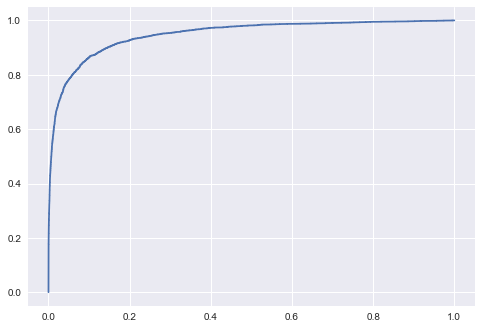

In [70]:
a = metrics.roc_curve(y_test, gs_nb_toxic.predict_proba(x_test)[:,1])
plt.plot(a[0],a[1])
plt.show()

**Train multipyl classifiers**

issue:
  - fixed  <s>is_stop dose not work with en_core_web_lg, works with en_core_web_sm</s>  
  - is_oov dose not work with en_core_web_sm, works with en_core_web_lg

notes:
 - keep -PRON-
 - ngrams?
 - vector from en_core_web_lg token?
 - other tokenizer?
 - tfidf with analyzer=char
 
 
   

data: 
   - v1. en_core_web_lg, nlp.pip, is_stop dose not work with lg model, http address not removed
   - v2. en_core_web_sm, nlp.pip, stop words removed, http address removed, is_oov dose not work with sm model
   - v3. en_core_web_lg, tokenize.pip http address removed, stop word remove fixed, is_oov working
   - v4. en_core_web_lg, tokenize.pip, processed on full set (train and test set combined)

In [32]:
# dose not work, x, y need to have same number of rows

# class ItemSelector(BaseEstimator, TransformerMixin):
#     def __init__(self, key='comment', idx=None):
#         self.key = key
#         self.idx = idx

#     def fit(self, x, y=None):
#         return(self)

#     def transform(self, data_dict):
#         if self.key == 'comment':
#             return(data_dict[self.key])
#         elif self.key == 'features':
#             return(data_dict[self.key][self.idx,:])

# class CommentFeatureExtractor(BaseEstimator, TransformerMixin):
#     '''
#     input data should contain a column of cleaned comments from both train and test set
#     (first n_train samples from train set, the rest from test set), 
#     as well as featurs generated from comments ready for training
#     '''
#     def __init__(self, n_train=None):
#         self.n_train = n_train
        
#     def fit(self, x, y=None):
#         return(self)

#     def transform(self, full_set):
#         data = {}
#         data['comment'] = full_set.cleaned_text
#         data['features'] = full_set.drop('cleaned_text',axis=1)[:self.n_train]
#         return(data)
    
# class MyTfidf(BaseEstimator, TransformerMixin):
#     def __init__(self, max_df=1.0, min_df=1, max_features=None, idx=None, analyzer='word'):
#         self.max_df = max_df
#         self.min_df = min_df
#         self.max_features = max_features
#         self.idx = idx
#         self.analyzer = analyzer
        
#     def fit(self, x, y=None):
#         return(self)
    
#     def transform(self, comments):
#         if self.analyzer == 'word':
#             ngram_range=(1, 1)
#         elif self.analyzer == 'char':
#             ngram_range=(1, 4)
#         Vectorizer_word = TfidfVectorizer(max_df=self.max_df, ngram_range=ngram_range, min_df=self.min_df, 
#                                           max_features=self.max_features, analyzer=self.analyzer,)
#         word_vector = Vectorizer_word.fit_transform(comments)
#         return(word_vector[self.idx])

# # pipeline for training multipule classifiers
# pip = Pipeline([
#             # Extract comments and features columns
#             ('commentfeature', CommentFeatureExtractor()),
            
#             # use FeatureUnion to combine features from tfidf and other already generated features
#             ('union', FeatureUnion(
#                 transformer_list=[
                    
#                     # pipeline to generate features from comments using tfidf analyzed by word
#                     ('tfidf_word', Pipeline([
#                         ('selector', ItemSelector(key='comment')),
#                         ('tfidf', MyTfidf(analyzer='word'))
#                     ])),
                    
#                     # pipeline to generate features from comments using tfidf analyzed by char
#                     ('tfidf_char', Pipeline([
#                         ('selector', ItemSelector(key='comment')),
#                         ('tfidf', MyTfidf(analyzer='char'))
#                     ])),
                    
#                     # get other generated features 
#                     ('other_features', Pipeline([
#                         ('selector', ItemSelector(key='features'))
#                     ]))
#                 ], 
#                 n_jobs=-1,
#                 transformer_weights={
#                     'tfidf_word': 1.0,
#                     'tfidf_char': 1.0,
#                     'other_features': 1.0,
#                 }
#             )),
            
#             # run MNB model on x_train, y_train
#             ('mnb', MultinomialNB())
#             ])

# parameters = {'commentfeature__n_train': [n_train],\
#               'union__tfidf_word__tfidf__max_df': [0.6, 0.7, 0.8, 0.9],\
#               'union__tfidf_word__tfidf__min_df': [0, 10, 30, 100],\
#               'union__tfidf_word__tfidf__idx': [train_idx],\
#               'union__tfidf_char__tfidf__max_df': [1],\
#               'union__tfidf_char__tfidf__min_df': [0],\
#               'union__tfidf_char__tfidf__idx': [train_idx],\
#               'union__other_features__selector__idx': [train_idx],\
#               'nb__alpha': [1, 0.3, 0.1, 0.03, 0.01, 0.003]}
# nb_toxic = GridSearchCV(pip, parameters, n_jobs=-1, scoring = 'roc_auc', verbose=1)
# nb_toxic.fit(full_set.drop(['comment_text', 'id', 'identity_hate', 'insult', 'obscene', 'severe_toxic', 'threat'], 
#                            axis=1),
#             y_train)